In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
#create a dictionary that preprocesses the images
#the numbers were chosen from the pytorch documentation linked in README.md

#add augmentation to only the training data 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomOrder([transforms.RandomChoice([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15)])]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])     
    ])                              
}

#directory 
data_dir = './data'

# dataloaders for train, valid and test datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=0) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#class names {malignant, benign}
class_names = image_datasets['train'].classes

#device being used to train and load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

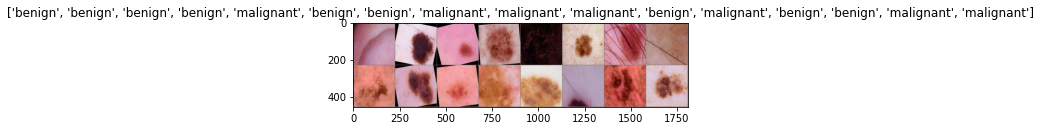

In [5]:
#show some images that we are working with
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [8]:
#function that trains and saves the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, save=False, path="skin_cancer_classifier.pth.tar"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if save:
    # save the best model
        state = {'epoch': epoch, 'state_dict': model.state_dict(),'optimizer': optimizer.state_dict()}
        torch.save(state, path)
        torch.save(model.state_dict(), path)
    return model

In [16]:
#function to visualize the trained model and the classified images from the validation data
def visualize_model(model, num_images=16):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [10]:
#use the pretrained model resnet18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

#change last layer to fit two classes
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#using gradient descent optimization
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
#train the model and save it 
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, save=True, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4591 Acc: 0.7749
val Loss: 0.3593 Acc: 0.8258

Epoch 1/24
----------
train Loss: 0.4011 Acc: 0.8108
val Loss: 0.3223 Acc: 0.8515

Epoch 2/24
----------
train Loss: 0.3406 Acc: 0.8432
val Loss: 0.3007 Acc: 0.8485

Epoch 3/24
----------
train Loss: 0.3370 Acc: 0.8371
val Loss: 0.3086 Acc: 0.8424

Epoch 4/24
----------
train Loss: 0.2974 Acc: 0.8649
val Loss: 0.2990 Acc: 0.8545

Epoch 5/24
----------
train Loss: 0.2923 Acc: 0.8644
val Loss: 0.3059 Acc: 0.8500

Epoch 6/24
----------
train Loss: 0.2886 Acc: 0.8629
val Loss: 0.2861 Acc: 0.8667

Epoch 7/24
----------
train Loss: 0.2596 Acc: 0.8796
val Loss: 0.2885 Acc: 0.8712

Epoch 8/24
----------
train Loss: 0.2376 Acc: 0.8897
val Loss: 0.2798 Acc: 0.8606

Epoch 9/24
----------
train Loss: 0.2266 Acc: 0.8988
val Loss: 0.2954 Acc: 0.8621

Epoch 10/24
----------
train Loss: 0.2255 Acc: 0.8998
val Loss: 0.2765 Acc: 0.8727

Epoch 11/24
----------
train Loss: 0.2398 Acc: 0.8958
val Loss: 0.2747 Acc: 0.8833

Ep

tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')


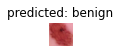

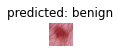

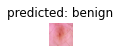

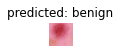

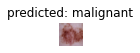

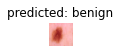

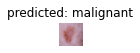

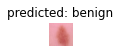

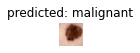

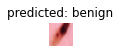

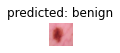

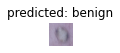

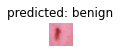

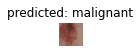

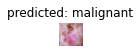

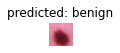

In [17]:
visualize_model(model_ft)

In [13]:
def test(loaders, model, use_cuda):
#Modified testing loop courtesy of Udacity.
    # monitor test loss and accuracy
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda')
    test_loss = 0.
    correct = 0.
    total = 0.
    side_of_rink = 0.
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        with torch.no_grad():
            # move to GPU
            if use_cuda:
                data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            preds = output.data.max(1, keepdim=True)[1]
            #print(preds, target)
            # compare predictions to true label
            #print(batch_idx)
            correct += np.sum(np.squeeze(preds.eq(target.data.view_as(preds))).cpu().numpy())
            total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [14]:
test(dataloaders, model_ft, True)

Test Loss: 0.288024


Test Accuracy: 84% (557/660)
